In [1]:
import numpy as np
import sys, os, pickle, h5py, time

from iminuit import Minuit
from scipy import stats, optimize, ndimage, signal

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from IPython.display import clear_output
from astropy import coordinates as coord

In [2]:
###########################
# Setup Plotting Defaults #
###########################
# For more options see https://matplotlib.org/users/customizing.html

# Commands for high detail plots (much larger in file size though)
#mpl.rcParams['agg.path.chunksize'] = 1000
#mpl.rcParams['savefig.dpi'] = 1000

# Line styles
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.antialiased'] = True
mpl.rcParams['lines.dashed_pattern'] = 2.8, 1.5
mpl.rcParams['lines.dashdot_pattern'] = 4.8, 1.5, 0.8, 1.5
mpl.rcParams['lines.dotted_pattern'] = 1.1, 1.1
mpl.rcParams['lines.scale_dashes'] = True

# Default colors
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler('color',['cornflowerblue','forestgreen','maroon','goldenrod','firebrick','mediumorchid'])


# Fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['font.sans-serif'] = 'CMU Sans Serif, DejaVu Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif'
mpl.rcParams['text.usetex'] = True

# Axes
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['axes.labelpad'] = 9.0
                                                  
                                                  
# Tick marks - the essence of life
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 2.5
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True

# Legend
mpl.rcParams['legend.fontsize'] = 22
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1.0
#mpl.rcParams['legend.edgecolor'] = 'black'
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderpad'] = 0.4 # border whitespace
mpl.rcParams['legend.labelspacing'] = 0.5 # the vertical space between the legend entries
mpl.rcParams['legend.handlelength'] = 1.5 # the length of the legend lines
mpl.rcParams['legend.handleheight'] = 0.7 # the height of the legend handle
mpl.rcParams['legend.handletextpad'] = 0.5 # the space between the legend line and legend text
mpl.rcParams['legend.borderaxespad'] = 0.5 # the border between the axes and legend edge
mpl.rcParams['legend.columnspacing'] = 2.0 # column separation


# Figure size
mpl.rcParams['figure.figsize'] = 24, 8

# Save details
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1


def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))


In [3]:
def rebin(e, spectrum, E_Shift = 0):
    '''
    This method takes a spectrum specified by energies `e` [keV] and
    a spectrum `spectrum` [counts / (t * year * keV)] and rebins it to the energy resolution
    of the data.
    
    Optional argument `E_Shift` [keV] shifts the interpolated output by the specified amount
    ''' 
    
    interp_energies = np.linspace(e[0], e[-1], int(1e5))
    interp_spectrum = np.interp(interp_energies, e, spectrum)

    
    interp_energies += E_Shift
    
    binned_spectrum = np.zeros_like(emins)
    for i in range(len(binned_spectrum)):
        
        min_index = np.searchsorted(interp_energies, emins[i])
        max_index = np.searchsorted(interp_energies, emaxs[i])
        
        binned_spectrum[i] = np.trapz(interp_spectrum[min_index:max_index], interp_energies[min_index:max_index])
        
    
    return np.nan_to_num(binned_spectrum) / binsize


def hires_rebin(e, spectrum, E_Shift = 0):
    '''
    This method takes a spectrum specified by energies `e` [keV] and
    a spectrum `spectrum` [counts / (t * year * keV)] and rebins it to the energy resolution
    of the data.
    
    Optional argument `E_Shift` [keV] shifts the interpolated output by the specified amount
    ''' 
    
    interp_energies = np.linspace(e[0], e[-1], int(1e5))
    hires_binsize = np.diff(interp_energies)[0]
    
    interp_spectrum = np.interp(interp_energies, e, spectrum, left = 0, right = 0)
    
    
    interp_spectrum /= np.sum(interp_spectrum * hires_binsize*exposure)
    
    return interp_energies, interp_spectrum

In [4]:
exposure = .658

stacked_archive = h5py.File('../Data/Stacked_Data_210keV.h5', 'r', driver="core")
joint_archive = h5py.File('../Data/Joint_Data_210keV.h5', 'r', driver="core")
model_archive = h5py.File('../Data/ModelArchive.h5', 'r', driver="core")

e_centers = np.array((stacked_archive['BinEdges'][1:] + stacked_archive['BinEdges'][:-1]) / 2)
emins = np.array(stacked_archive['BinEdges'][:-1])
emaxs = np.array(stacked_archive['BinEdges'][1:])
binsize = np.diff(e_centers)[0]


ens_ABC = np.array(model_archive['ABC_Model'][0])
flux_ABC = np.array(model_archive['ABC_Model'][1])

# Analysis of the Stacked SR1 Data

In [5]:
stacked_flux = np.array(stacked_archive['Flux'])
stacked_error = np.array(stacked_archive['FluxError'])

central_values = np.array(stacked_archive['Prior_Centers'])
std = np.array(stacked_archive['Prior_STD'])
bkg_component_data = np.array(stacked_archive['BackgroundComponents'])

In [6]:
def objective(x, abc_spectrum):
    
    signal = x[0]* abc_spectrum
    x = x[1:]

    prior_locs = np.where(std > 0)
    prior = np.sum((x- central_values)[prior_locs]**2 / std[prior_locs]**2)

    background = np.sum(x[:, None] * bkg_component_data, axis = 0)

    expected = background + signal
    chiSq =  np.sum((stacked_flux -expected)[1:]**2 / stacked_error[1:]**2)

    return chiSq + prior, expected

guess = np.append(0, np.array(stacked_archive['Prior_Centers']))
limits = np.vstack(([-2000, 2000], np.array(stacked_archive['Param_Bounds'])))

In [7]:
m = Minuit.from_array_func(lambda x: objective(x, 0)[0], guess, limit=limits,
                           error = np.minimum(1, .1 * np.diff(limits, axis = 1)),
                           errordef = 1e0)
m.fixed['x0'] =True
m.migrad()

bkg_fit = np.array(m.values.values())
refit_bkg = objective(np.array(m.values.values()), 0)[1]

In [8]:
label_list = [r'$^{214}$Pb', r'$^{85}$Kr', r'Materials', r'$^{136}$Xe', r'Solar $\nu$',
              r'$^{133}$Xe', r'$^{131\mathrm{m}}$Xe', r'$^{125}$I', r'$^{83\mathrm{m}}$Kr',
              r'$^{124}$Xe']

color_list = [np.array([11, 36, 251]) / 255, np.array([128, 128, 128]) / 255, np.array([127, 15, 126]) / 255,
              np.array([252, 40, 252]) / 255, np.array([163, 43, 46]) / 255, np.array([45, 255, 254]) / 255,
              np.array([60, 203, 62]) / 255, np.array([2,2, 126]) / 255, np.array([9, 99, 12]) / 255,
              np.array([253, 164, 40]) / 255]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


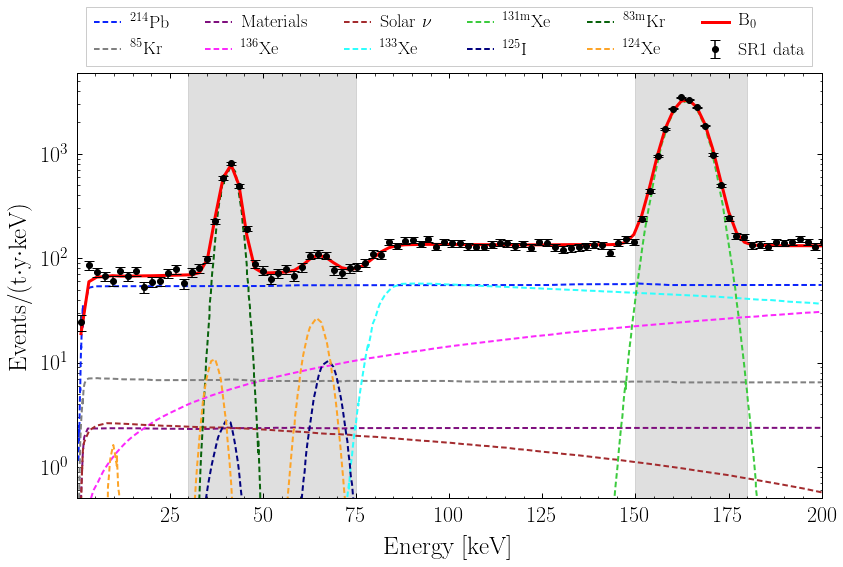

In [9]:
# Figure size
mpl.rcParams['figure.figsize'] = 12, 8
ax = plt.subplot(111)

for i in range(len(label_list)):
    ax.plot(np.array(stacked_archive['HiResEnergies'][i]),
            m.values['x' + str(i+1)]*np.array(stacked_archive['HiResFlux'][i]),
            ls = '--', lw = 2, color = color_list[i], label = label_list[i])

ax.plot(e_centers, refit_bkg, c = 'red', lw =3,
         label = 'B$_0$')

ax.errorbar(e_centers, stacked_archive['Flux'], stacked_archive['FluxError'], c = 'black', fmt ='o', capsize = 5,
             label = 'SR1 data')
   


ax.axvspan(30, 75, color="grey", alpha = .25)
ax.axvspan(150, 180, color="grey", alpha = .25)


ax.set_yscale('log')
ax.set_ylim(5e-1, None)
ax.set_xlim(0, 200)
ax.set_xticks([25, 50, 75, 100, 125, 150, 175, 200])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.175),
          ncol=6, fancybox=False, shadow=False, fontsize = 18)

plt.xlabel('Energy [keV]')
plt.ylabel('Events/(t$\cdot$y$\cdot$keV)')
#ax.set_xlim(150, 180)
plt.tight_layout()
plt.savefig('../Plots/Fig5.pdf')

plt.show()

In [10]:
def StackedChiSq(E_Shift):
    '''
    This method components the improvement of the chi^2 statistic from the inclusion of an
    ABC spectrum shifted by `E_Shift` [keV] when fitting to data `data` with error `errors`.
    The background amplitude is not allowed to float.
    
    The optional arguments `E_Min` and `E_Max` [keV] specify lower and upper energy bounds 
    for the range over which we perform the fit. These bounds are shifted by `E_Shift`. By
    default, the window is 6 keV wide as in [2006.09721].
    
    Return the best fit signal amplitude, the 1\sigma and 2\sigma upper limits on the 
    signal amplitude, and the change in chi^2 statistic.
    '''
    
    
    abc_spectrum = rebin(ens_ABC, flux_ABC, E_Shift = E_Shift)
    abc_spectrum /= np.sum(abc_spectrum * (np.diff(e_centers)[0]*exposure))
    
    abc_spectrum[np.where(emins < 1 + E_Shift)] = 0
    
    # First, do the fit using the refit background model
    m = Minuit.from_array_func(lambda x: objective(x, abc_spectrum)[0], guess, limit = limits,
                               error = 1e-2*(limits[:, 1] - limits[:, 0]), errordef = 1e0)
    m.fixed['x0'] = True
    m.migrad()
    NullChiSq = m.fval
    
    
    # Next, fix the continuum params and fit a signal model
    for i in range(len(guess)):
        if i == 0:
            m.fixed['x' + str(i)] = False
        else:
            m.fixed['x'+str(i)] = True
            
    m.migrad()

    SignalChiSq = m.fval
    
    FixedTS = NullChiSq - SignalChiSq
    
    
    # First, do the fit using the refit background model
    m = Minuit.from_array_func(lambda x: objective(x, abc_spectrum)[0], bkg_fit, limit = limits,
                               error = 1e-1*(limits[:, 1] - limits[:, 0]), errordef = 1e0)
    m.migrad()
    ProfiledChiSq = m.fval
    
    ProfiledTS = NullChiSq - ProfiledChiSq
    return FixedTS, ProfiledTS

In [11]:
Stacked_TS_Values = np.zeros((3201, 2))
E_Shifts = np.linspace(0, 200, 3201)

for i in range(len(E_Shifts)):
    print(i)
    Stacked_TS_Values[i]= StackedChiSq(E_Shifts[i])
clear_output()

# Analyze with the Joint Likelihood

In [12]:
joint_fluxes = np.array(joint_archive['Flux'])
joint_errors =np.array(joint_archive['FluxError'])
joint_bkgs = np.array(joint_archive['X1T_Background'])

In [13]:
def JointChiSq(E_Shift):
    
    def objective(x, abc_spectrum):
        return np.sum((joint_fluxes - x * abc_spectrum - joint_bkgs)[:, 1:]**2 / joint_errors[:, 1:]**2)
    
    abc_spectrum = rebin(ens_ABC, flux_ABC, E_Shift = E_Shift)
    abc_spectrum /= np.sum(abc_spectrum * (np.diff(emins)[0]*exposure))
    

    #abc_spectrum[np.where(emins <= 1 + E_Shift)] = 0
    
    NullChiSq = objective(0, 0)
    
    n = Minuit(lambda x: objective(x, abc_spectrum), x = 0, error_x = 1, limit_x = [None, None], errordef = 1)
    n.migrad()

    return NullChiSq - n.fval

def IndependentChiSq(E_Shift, index):
    
    def objective(x, abc_spectrum):
        return np.sum((joint_fluxes - x * abc_spectrum - joint_bkgs)[index, 1:]**2 / joint_errors[index, 1:]**2)
    
    abc_spectrum = rebin(ens_ABC, flux_ABC, E_Shift = E_Shift)
    abc_spectrum /= np.sum(abc_spectrum * (np.diff(emins)[0]*exposure))
    

    #abc_spectrum[np.where(emins <= 1 + E_Shift)] = 0
    
    NullChiSq = objective(0, 0)
    
    n = Minuit(lambda x: objective(x, abc_spectrum), x = 0, error_x = 1, limit_x = [None, None], errordef = 1)
    n.migrad()

    return NullChiSq - n.fval

In [14]:
Joint_TS = np.zeros_like(E_Shifts)

for i in range(E_Shifts.shape[0]):
    print(i)
    Joint_TS[i] = JointChiSq(E_Shifts[i])
clear_output()


Independent_TS = np.zeros((len(E_Shifts), 2))
for i in range(E_Shifts.shape[0]):
    print(i)
    Independent_TS[i, 0] = IndependentChiSq(E_Shifts[i], 0)
    Independent_TS[i, 1] = IndependentChiSq(E_Shifts[i], 1)
clear_output()

# Make Various Plots

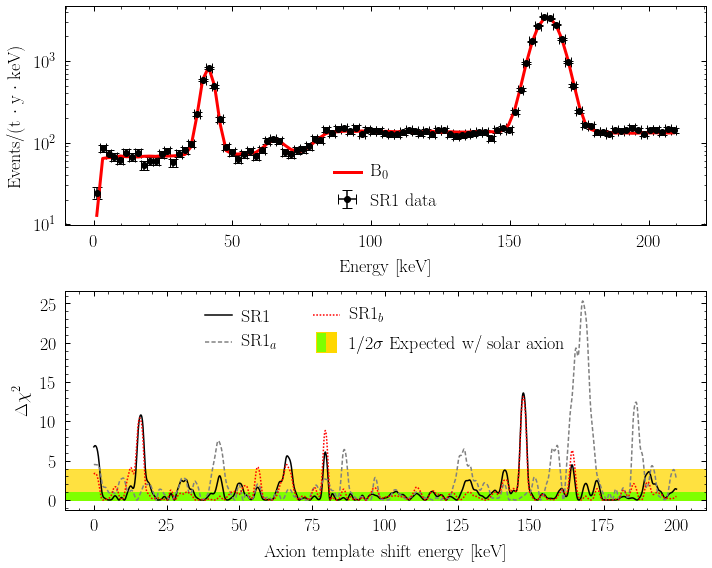

In [15]:
fig, axs = plt.subplots(nrows = 2,figsize=(10,8))

fontsize=18


axs[0].errorbar(e_centers, stacked_archive['Flux'], yerr = stacked_archive['FluxError'],
                xerr = binsize/2, c = 'black', fmt ='o', capsize = 5, label = 'SR1 data')
axs[0].plot(e_centers, stacked_archive['X1T_Background'], lw = 3, c = 'red',
            label = 'B$_0$')

axs[0].set_xlabel('Energy [keV]',fontsize=fontsize)
axs[0].set_ylabel(r'Events/(t $\cdot$ y $\cdot$ keV)',fontsize=fontsize)
axs[0].set_yscale('log')
axs[0].legend(frameon = False, loc = 'lower center', fontsize =fontsize)
   

axs[1].plot(E_Shifts, Joint_TS, c = 'black', zorder = 11, label = 'SR1')
axs[1].plot(E_Shifts, Independent_TS[:, 0], c = 'grey', ls = '--',
            zorder = 11, label = 'SR1$_{a}$')
axs[1].plot(E_Shifts, Independent_TS[:, 1], c = 'red', ls = ':',
            zorder = 11, label = 'SR1$_{b}$')

#axs[1].plot(E_Shifts, Fit_Results_prof[:, 1], c = 'black',linestyle="dashed", zorder = 11, label = 'Unmasked')
#axs[1].plot(E_Shifts, Mask_Fit_Results[:, 1], c = 'grey', zorder = 10, label = 'Masked')


#plt.plot(E_Shifts, np.median(MC_Fit_Results[:, :, 3], axis = 0), '-s', c = 'black')
axs[1].axhspan(0, 4, color = 'gold', alpha = .75)
axs[1].axhspan(0, 1, color = 'chartreuse', alpha = 1.)


axs[1].set_xlabel('Axion template shift energy [keV]',fontsize=fontsize)
axs[1].set_ylabel(r'$\Delta \chi^2$',fontsize=fontsize)




msize=20
m3, = plt.plot([], [], c='chartreuse' , marker='s', markersize=msize,
              fillstyle='left', linestyle='none',alpha=1.0)
m4, = plt.plot([], [], c='gold' , marker='s', markersize=msize,
              fillstyle='right', linestyle='none',alpha=1.0)

handles,labels = axs[1].get_legend_handles_labels()
handles1 = [handles[0], handles[1], handles[2], (m3 ,m4)]
labels1 = [labels[0], labels[1], labels[2],  r'$1/2\sigma$ Expected w/ solar axion']

axbox = axs[1].get_position()
x_value= -0.1
y_value= .65

legend1 = axs[1].legend(handles1,labels1, frameon=False, fontsize = fontsize,
                        ncol = 2, loc = 'upper center')


axs[0].tick_params(axis='x', labelsize= fontsize)
axs[0].tick_params(axis='y', labelsize= fontsize)
axs[1].tick_params(axis='x', labelsize= fontsize)
axs[1].tick_params(axis='y', labelsize= fontsize)

plt.tight_layout()
plt.subplots_adjust(hspace = .3)

plt.savefig('../Plots/Fig2.pdf')
plt.show()

In [16]:
mask = np.where(E_Shifts <= 7)
accepted_locs = np.setdiff1d(np.arange(len(E_Shifts)), mask)

/sw/arcts/centos7/python3.6-anaconda/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  
/sw/arcts/centos7/python3.6-anaconda/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  
/sw/arcts/centos7/python3.6-anaconda/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:19: VisibleD

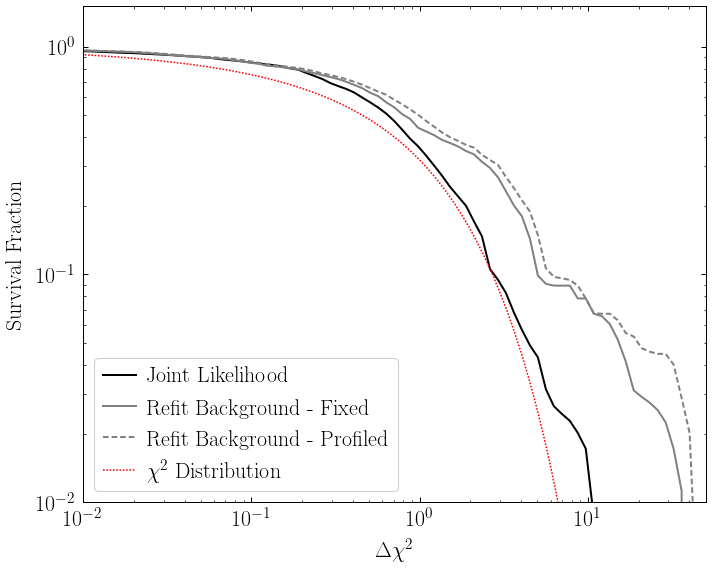

In [17]:
# Figure size
mpl.rcParams['figure.figsize'] = 10, 8

fontsize=22#18

#num_bins = 20
bins=np.geomspace(1e-3,50.,100)
counts, bin_edges = np.histogram(Joint_TS[accepted_locs], bins=bins, normed=True)
cdf = np.cumsum (counts)
plt.plot(bin_edges[1:], 1-cdf/cdf[-1],'k-',label="Joint Likelihood", c = 'black', lw = 2)


bins=np.geomspace(1e-3,50.,100)
counts, bin_edges = np.histogram(Stacked_TS_Values[:, 0][accepted_locs], bins=bins, normed=True)
cdf = np.cumsum (counts)
plt.plot(bin_edges[1:], 1-cdf/cdf[-1],'k-',label="Refit Background - Fixed", c = 'grey', lw = 2)

bins=np.geomspace(1e-3,50.,100)
counts, bin_edges = np.histogram(Stacked_TS_Values[:, 1][accepted_locs], bins=bins, normed=True)
cdf = np.cumsum (counts)
plt.plot(bin_edges[1:], 1-cdf/cdf[-1],'k-',label="Refit Background - Profiled", c = 'grey', lw = 2, ls = '--')


'''
counts, bin_edges = np.histogram(Fit_Results[:, 3][accepted_locs], bins=bins, normed=True)
cdf = np.cumsum (counts)
plt.plot(bin_edges[1:], 1-cdf/cdf[-1],'k--',label="masked data (observed)")

counts, bin_edges = np.histogram(TS_Corrected[accepted_locs], bins=bins, normed=True)
cdf = np.cumsum (counts)
plt.plot(bin_edges[1:], 1-cdf/cdf[-1],'b--',label="masked data (adjusted)")
''' 

x_vals = np.geomspace(1e-3, 2e1, 100)
y_vals = stats.chi2.sf(x_vals, df = 1)

plt.plot(x_vals, y_vals, c='black',color="red",linestyle="dotted", label = r'$\chi^2$ Distribution')

plt.ylim(1e-2, 1.5)
plt.xlim(1e-2, 50)

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(ncol = 1, fontsize = fontsize,loc=3)
plt.xlabel(r'$\Delta \chi^2$',fontsize=fontsize)
plt.ylabel(r'Survival Fraction',fontsize=fontsize)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.savefig('../Plots/Fig3.pdf')

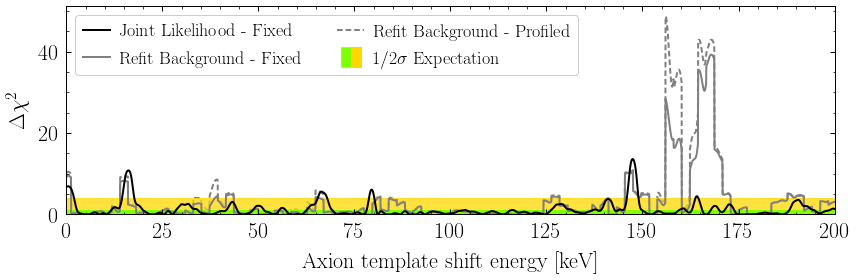

In [18]:
fig, axs = plt.subplots(nrows = 1,figsize=(12,4))

fontsize=22
#fig = plt.figure(figsize=(12,8))


axs.plot(E_Shifts, Joint_TS, c = 'black', zorder = 10, label = 'Joint Likelihood - Fixed', lw = 2)


axs.plot(E_Shifts, Stacked_TS_Values[:, 0], c = 'grey', zorder = 1, label = 'Refit Background - Fixed', lw = 2)
axs.plot(E_Shifts, Stacked_TS_Values[:, 1], c = 'grey', ls = '--', zorder = 0, label = 'Refit Background - Profiled', lw = 2)


#plt.plot(E_Shifts, np.median(MC_Fit_Results[:, :, 3], axis = 0), '-s', c = 'black')
axs.axhspan(0, 4, color = 'gold', alpha = .75)
axs.axhspan(0, 1, color = 'chartreuse', alpha = 1.)


axs.set_xlabel('Axion template shift energy [keV]',fontsize=fontsize)
axs.set_ylabel(r'$\Delta \chi^2$',fontsize=fontsize)
axs.legend()
#axs.set_yscale('log')



msize=20
m3, = plt.plot([], [], c='chartreuse' , marker='s', markersize=msize,
              fillstyle='left', linestyle='none',alpha=1.0)
m4, = plt.plot([], [], c='gold' , marker='s', markersize=msize,
              fillstyle='right', linestyle='none',alpha=1.0)
 
handles,labels = axs.get_legend_handles_labels()
handles1 = [handles[0], handles[1], handles[2], (m3 ,m4)]
labels1 = [labels[0], labels[1], labels[2], r'$1/2\sigma$ Expectation']

axbox = axs.get_position()
x_value= -0.1
y_value= .65

legend1 = axs.legend(handles1,labels1, loc='upper left',frameon=True, fontsize = fontsize-4, framealpha = 1.,
                     ncol = 2)


axs.set_ylim(0, None)

axs.set_xlim(0,200)

#axs[0].set_xticklabels(fontsize=fontsize)
axs.tick_params(axis='x', labelsize= fontsize)
axs.tick_params(axis='y', labelsize= fontsize)
plt.tight_layout()
plt.savefig('../Plots/Fig6.pdf')
plt.show()